<a href="https://colab.research.google.com/github/kwanderer/MachineLearning/blob/main/Keras_Multivariate_time_series_classification_using_LSTM_ipynb_txt_random.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import keras
from keras.layers import LSTM, Dropout, Dense
import tensorflow as tf
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

In [ ]:
from google.colab import drive
import os
drive.mount('/content/gdrive')
os.chdir("/content/gdrive/MyDrive/Colab Notebooks/data/")
data = pd.read_csv("creditcard.csv")


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [ ]:
#from enum import unique
np.unique(data['Class'])
data.count(1)

0         31
1         31
2         31
3         31
4         31
          ..
284802    31
284803    31
284804    31
284805    31
284806    31
Length: 284807, dtype: int64

In [ ]:
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [ ]:
rec_count = len(data)
rec_count

284807

In [ ]:
sequence_length = 10

In [ ]:
def generate_data(X, y, sequence_length = 10, step = 1):
    X_local = []
    y_local = []
    for start in range(0, len(data) - sequence_length, step):
        end = start + sequence_length
        X_local.append(X[start:end])
        y_local.append(y[end-1])
    return np.array(X_local), np.array(y_local)

X_sequence, y = generate_data(data.loc[:, "V1":"V28"].values, data.Class)

In [ ]:
X_sequence.shape, y.shape


((284797, 10, 28), (284797,))

In [ ]:
def shuffle_in_unison(a, b):
    assert len(a) == len(b)
    shuffled_a = np.empty(a.shape, dtype=a.dtype)
    shuffled_b = np.empty(b.shape, dtype=b.dtype)
    permutation = np.random.permutation(len(a))
    for old_index, new_index in enumerate(permutation):
        shuffled_a[new_index] = a[old_index]
        shuffled_b[new_index] = b[old_index]
    return shuffled_a, shuffled_b

In [ ]:
X_sequence, y = shuffle_in_unison(X_sequence, y)

In [ ]:
model = keras.Sequential()
model.add(LSTM(100, input_shape = (10, 28)))
model.add(Dropout(0.5))
model.add(Dense(1, activation="sigmoid"))
model.compile(loss="binary_crossentropy"
              , metrics=[keras.metrics.binary_accuracy]
              , optimizer="adam")

model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 100)               51600     
                                                                 
 dropout_6 (Dropout)         (None, 100)               0         
                                                                 
 dense_6 (Dense)             (None, 1)                 101       
                                                                 
Total params: 51,701
Trainable params: 51,701
Non-trainable params: 0
_________________________________________________________________


In [ ]:
training_size = int(len(X_sequence) * 0.7)

In [ ]:
len(X_sequence)

284797

In [ ]:
X_train, y_train = X_sequence[:training_size], y[:training_size]
X_test, y_test = X_sequence[training_size:], y[training_size:]

In [ ]:
history = model.fit(X_train, y_train, batch_size=64, epochs=50)

Epoch 1/50
3115/3115 [==============================] - 37s 12ms/step - loss: 8.2930e-05 - binary_accuracy: 1.0000
Epoch 2/50
3115/3115 [==============================] - 35s 11ms/step - loss: 2.5161e-04 - binary_accuracy: 1.0000
Epoch 3/50
3115/3115 [==============================] - 36s 11ms/step - loss: 1.7650e-05 - binary_accuracy: 1.0000
Epoch 4/50
3115/3115 [==============================] - 36s 11ms/step - loss: 2.0017e-05 - binary_accuracy: 1.0000
Epoch 5/50
3115/3115 [==============================] - 38s 12ms/step - loss: 4.8506e-05 - binary_accuracy: 1.0000
Epoch 6/50
3115/3115 [==============================] - 35s 11ms/step - loss: 7.9327e-05 - binary_accuracy: 1.0000
Epoch 7/50
3115/3115 [==============================] - 35s 11ms/step - loss: 1.2459e-04 - binary_accuracy: 1.0000
Epoch 8/50
3115/3115 [==============================] - 35s 11ms/step - loss: 2.9820e-05 - binary_accuracy: 1.0000
Epoch 9/50
3115/3115 [==============================] - 35s 11ms/step - loss: 5.

In [ ]:
model.evaluate(X_test, y_test)

2670/2670 [==============================] - 9s 3ms/step - loss: 0.0110 - binary_accuracy: 0.9994


[0.011018185876309872, 0.9993913769721985]

In [ ]:
y_test_prob = model.predict(X_test, verbose=1)

2670/2670 [==============================] - 9s 3ms/step


In [ ]:
y_test_pred = np.where(y_test_prob > 0.5, 1, 0)

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
confusion_matrix(y_test, y_test_pred)

array([[85285,    16],
       [   36,   103]])

Confusion matrix, without normalization
[[85285    16]
 [   36   103]]
Normalized confusion matrix
[[1.00e+00 1.88e-04]
 [2.59e-01 7.41e-01]]


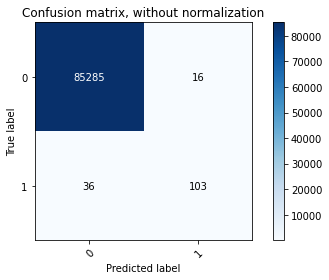

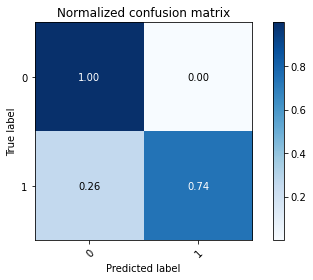

In [ ]:
class_names = np.array(['0', '1'])

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    #plt.xlim(-0.5, len(np.unique(y))-0.5)
    #plt.ylim(len(np.unique(y))-0.5, -0.5)
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_test_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_test_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [ ]:
def plot_learningCurve(history, epoch):
  # Plot training & validation accuracy values
  epoch_range = range(1, epoch+1)
  plt.plot(epoch_range, history.history['binary_accuracy'])
  plt.plot(epoch_range, history.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()

  # Plot training & validation loss values
  plt.plot(epoch_range, history.history['loss'])
  plt.plot(epoch_range, history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()